In [ ]:
#Run once per session
!pip install -U fastai
!pip install kornia -q
!pip install timm

     |████████████████████████████████| 194kB 6.2MB/s 
     |████████████████████████████████| 12.8MB 192kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 276kB 4.3MB/s 
     |████████████████████████████████| 296kB 5.8MB/s 


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, shutil
import gc
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.callback.cutmix import CutMix
from timm import create_model
from kornia.losses import focal
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path("/content/drive/My Drive/DS541/")
path.ls()

(#5) [Path('/content/drive/My Drive/DS541/test'),Path('/content/drive/My Drive/DS541/val'),Path('/content/drive/My Drive/DS541/train'),Path('/content/drive/My Drive/DS541/models'),Path('/content/drive/My Drive/DS541/visualize_test.csv')]

In [ ]:
model_path = Path(path/'models')
train_path = Path(path/'train')
train_states = list(train_path.ls())

for i in range(len(train_states)):
  print('%s: %i' %(os.listdir(train_path)[i],len(train_states[i].ls())))

VeryMildDemented: 1165
MildDemented: 466
ModerateDemented: 33
NonDemented: 1664


# Data Loader

In [ ]:
def get_data(img_size, bs):
  item_tfms = RandomResizedCrop(250, min_scale=0.80)

  batch_tfms = [*aug_transforms(size=img_size, do_flip=True, flip_vert=False, max_rotate=20.0, max_zoom=1.1, 
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.7, xtra_tfms=None), Normalize()]

  data = ImageDataLoaders.from_folder(path, train='train', valid='val', 
                                      bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms)

  return data

In [ ]:
bs = 32
img_size = 224
data = get_data(img_size, bs)

In [ ]:
print(f'number of train images: {len(data.train_ds)}')
print(f'number of validate images: {len(data.valid_ds)}')

number of train images: 3328
number of validate images: 767


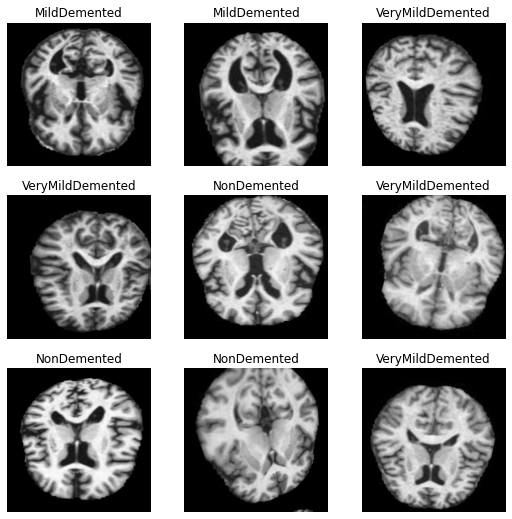

In [ ]:
data.show_batch(max_n=9)

# Define Focal Lost

In [ ]:
class CustomFocalLoss(focal.FocalLoss):
    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(CustomFocalLoss, self).__init__(alpha, gamma, reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [ ]:
kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'}
loss_func = CustomFocalLoss(**kwargs)

# EffB0-ViT-tiny

## Modify Patch

- Retrieve the ViT code from timm Github https://github.com/rwightman/pytorch-image-models.
- To connect EfficientNet backbone with the embedding layer of vision transformer,  I modify HybridEmbed class of hybrid model to make it able to take flattening the spatial dimensions of the feature map (from EfficientNet) and projecting to the transformer dimension. The position embedding is also included as usual to retain positional information.



In [ ]:
def to_2tuple(x):
    if isinstance(x, collections.abc.Iterable):
        return x
    return (x, x)

In [ ]:
# Code From https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer_hybrid.py
class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, patch_size=1, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # NOTE Most reliable way of determining output dims is to run forward pass
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))
                if isinstance(o, (list, tuple)):
                    o = o[-1]  # last feature if backbone outputs list/tuple of features
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            if hasattr(self.backbone, 'feature_info'):
                feature_dim = self.backbone.feature_info.channels()[-1]
            else:
                feature_dim = self.backbone.num_features
        assert feature_size[0] % patch_size[0] == 0 and feature_size[1] % patch_size[1] == 0
        self.num_patches = feature_size[0] // patch_size[0] * feature_size[1] // patch_size[1]
        self.proj = nn.Conv2d(feature_dim, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.backbone(x)
        if isinstance(x, (list, tuple)):
            x = x[-1]  # last feature if backbone outputs list/tuple of features
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [ ]:
def eff0_ViT_tiny(pretrained=True):
  effb0 = create_model('efficientnet_b0', pretrained= pretrained)
  effb0_backbone = nn.Sequential(*list(effb0.children())[:-2])
  model = create_model('vit_deit_tiny_patch16_224', pretrained= pretrained, num_classes=4, drop_rate=0.0)
  model.patch_embed = HybridEmbed(backbone=effb0_backbone)
  # connect Backbone to ViT
  model.patch_embed.proj = nn.Conv2d(1280, model.embed_dim, kernel_size=(1, 1), stride=(1, 1))
  model.pos_embed = nn.Parameter(torch.zeros(1, model.patch_embed.num_patches + 1, model.embed_dim))
  # xavier initiallization to the new pos_embed
  nn.init.xavier_uniform_(model.pos_embed)
  return model

In [ ]:
model = eff0_ViT_tiny()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [ ]:
learn = Learner(data, model, metrics = [accuracy, F1Score(average='weighted'), RocAuc()], 
                opt_func=ranger, loss_func=loss_func)

In [ ]:
learn.summary()

VisionTransformer (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 112 x 112 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
SiLU                                                           
Conv2d                                    288        True      
BatchNorm2d                               64         True      
SiLU                                                           
____________________________________________________________________________
                     32 x 8 x 1 x 1      
Conv2d                                    264        True      
SiLU                                                           
____________________________________________________________________________
                     32 x 32 x 1 x 1     
Conv2d                                    288        True      
____________________________________________

## Training

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.00013182566908653826)

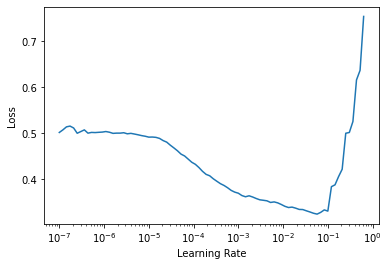

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, 3e-3, wd=0.01, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.222482,0.217285,0.507171,0.515091,0.739718,15:22


epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.181925,0.159107,0.620600,0.615172,0.844728,00:34
1,0.163097,0.147070,0.659713,0.661167,0.862286,00:34
2,0.153853,0.126524,0.685789,0.686469,0.883507,00:34
3,0.148553,0.127202,0.637549,0.632916,0.883796,00:34
4,0.150521,0.122482,0.715776,0.715216,0.895224,00:34
5,0.131567,0.120882,0.753585,0.747214,0.922191,00:34
6,0.111503,0.101526,0.741851,0.722852,0.945211,00:34
7,0.105984,0.086363,0.808344,0.806706,0.945078,00:34
8,0.085868,0.060038,0.842242,0.841376,0.971783,00:34
9,0.073509,0.046210,0.897001,0.897502,0.980656,00:34


In [ ]:
learn.save(model_path/'effb0_vit_tiny_20epochs')

Path('/content/drive/My Drive/DS541/models/effb0_vit_tiny_20epochs.pth')

### continue training

In [ ]:
learn.load(model_path/'effb0_vit_tiny_20epochs')
learn.fit_flat_cos(10, lr=1e-4, wd=0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.005671,0.005904,0.992177,0.992185,0.999717,08:19
1,0.004811,0.004659,0.992177,0.992171,0.999810,00:35
2,0.005039,0.004765,0.993481,0.993479,0.999730,00:34
3,0.005485,0.004112,0.993481,0.993470,0.999753,00:35
4,0.003400,0.004236,0.992177,0.992157,0.999584,00:35
5,0.002916,0.004429,0.992177,0.992177,0.999580,00:34
6,0.003186,0.004384,0.989570,0.989543,0.999693,00:35
7,0.003048,0.004025,0.986962,0.986973,0.999813,00:34
8,0.003043,0.004591,0.988266,0.988268,0.999783,00:34
9,0.002459,0.005247,0.988266,0.988263,0.999742,00:35


In [ ]:
learn.save(model_path/'effb0_vit_tiny')

Path('/content/drive/My Drive/DS541/models/effb0_vit_tiny_25.pth')

### Validation Confusion Matrix

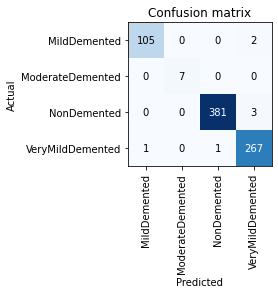

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.save(model_path/'effb0_vit_tiny')

Path('/content/drive/My Drive/DS541/models/effb0_vit_tiny.pth')

## Model Evaluation on Testing Set

In [ ]:
def evaluation_report(yhat,y):
  rocauc = roc_auc_score(y, yhat, multi_class='ovr')
  f1 = f1_score(y, yhat.argmax(axis=-1), average='weighted')
  print(f'accuracy: {accuracy(yhat, y)}')
  print(f'ROC AUC: {rocauc}')
  print(f'F1 Score: {f1}')

In [ ]:
test_path = Path(path/'test')
tst_fns = get_image_files(test_path)

In [ ]:
learn.load(model_path/'effb0_vit_tiny')

In [ ]:
# split label from Parent Folder
tst_lbl = [parent_label(fn) for fn in tst_fns]
dl = learn.dls.test_dl(tst_fns, with_labels=True)

In [ ]:
preds, y = learn.get_preds(dl=dl)

In [ ]:
learn =None
gc.collect()

5873

### Prediction

In [ ]:
evaluation_report(preds,y)
balanced_accuracy_score(y, preds.argmax(axis=-1))

accuracy: 0.9854085445404053
ROC AUC: 0.9993939674760994
F1 Score: 0.9854036329759507


0.9885308159722223

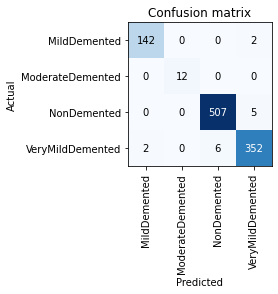

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99       144
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       0.99      0.99      0.99       512
VeryMildDemented       0.98      0.98      0.98       360

        accuracy                           0.99      1028
       macro avg       0.99      0.99      0.99      1028
    weighted avg       0.99      0.99      0.99      1028



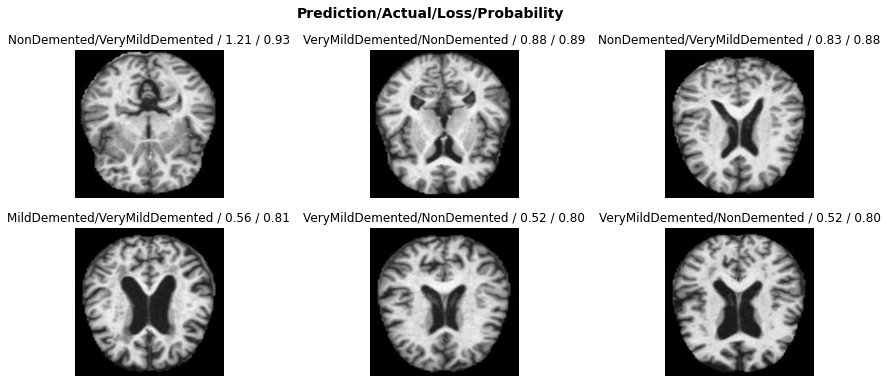

In [ ]:
interp.plot_top_losses(6, figsize=(15,6))

# Visulization of EffNet-ViT-tiny Classifications

In [ ]:
from sklearn.manifold import TSNE
import os, shutil
import seaborn as sns
from sklearn import manifold, datasets
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Perform t-SNE on the prediction probability of our model on test data (In short t-SNE is a nonlinear-dimensional reduction algorithm)

- We do this for visualizing model classifacations in a 2D plot

https://www.datacamp.com/community/tutorials/introduction-t-sne

In [ ]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds)

In [ ]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x1','x2','classes'])
prob_df['labels'] = tst_lbl
prob_df['fname'] = dl.items
prob_df['loss'] = interp.losses
prob_df.head()

,x1,x2,classes,labels,fname,loss
0,19.097609,40.532787,2.0,NonDemented,/content/drive/My Drive/DS541/test/NonDemented/nonDem100.jpg,0.000883
1,-16.979631,55.296753,2.0,NonDemented,/content/drive/My Drive/DS541/test/NonDemented/nonDem1006.jpg,0.000084
2,-11.910742,21.956347,2.0,NonDemented,/content/drive/My Drive/DS541/test/NonDemented/nonDem1000.jpg,0.000012
3,-32.307671,13.676258,2.0,NonDemented,/content/drive/My Drive/DS541/test/NonDemented/nonDem108.jpg,0.000017
4,-46.663826,34.575718,2.0,NonDemented,/content/drive/My Drive/DS541/test/NonDemented/nonDem1039.jpg,0.000042


In [ ]:
prob_df.to_csv(path/'visualize_test.csv',index=False)

In [ ]:
prob_df = pd.read_csv('/content/drive/My Drive/DS541/visualize_test.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


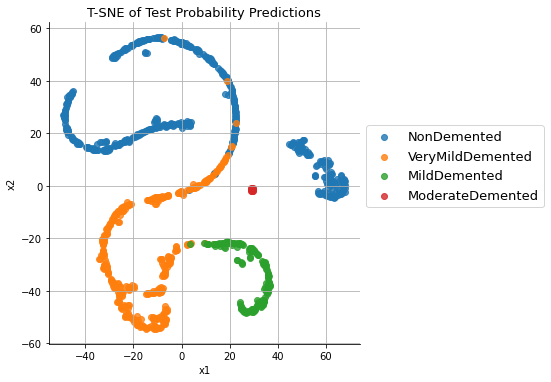

In [ ]:
g = sns.lmplot('x1', 'x2', data=prob_df, hue='labels', fit_reg=False, legend=False, height=5)
plt.legend(bbox_to_anchor= (1,0.7), fontsize=13)
plt.title('T-SNE of Test Probability Predictions', fontsize=13)
plt.grid()
plt.show()

In [ ]:
# modified to optionally filter by idxs

def visualize_scatter_with_images(scaled_data, df, idxs, figsize=(64,64), image_zoom=1, suffix=1):
    scaled_data = scaled_data[idxs]
    df = df.iloc[idxs]

    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    xx = (scaled_data[:,0])
    yy = (scaled_data[:,1])
    
    for (i,x,y) in zip(idxs,xx,yy):
        im = PIL.Image.open(df['fname'][i])
        im.thumbnail((45,45))
        img = OffsetImage(im, zoom=image_zoom, cmap='gray')
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    plt.title('Human Perspective', fontsize=25)
    plt.grid()
    ax.update_datalim(np.column_stack([xx,yy]))
    ax.autoscale()
    
#     fig.savefig(f'TSNE_{suffix}.jpg', bbox_inches = 'tight')
    return fig, ax

In [ ]:
probs_trans = np.array(prob_df[['x1','x2']].values)

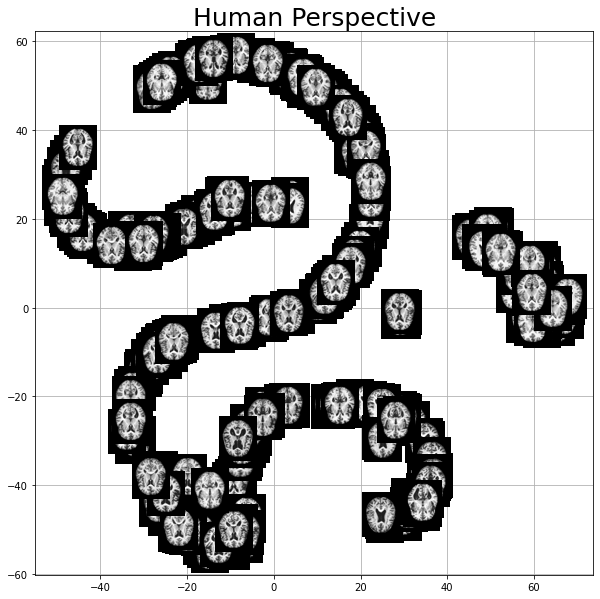

In [ ]:
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, range(0,len(prob_df),3), figsize=(10,10), image_zoom=1, suffix='probabilities')
plt.show()